In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Example dataset path - make sure this is the correct path
dataset_path = "/content/drive/MyDrive/dataset"  # Update this with the correct path

# Image Preprocessing function
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)  # Get class names from folder names

    # Iterate through each class folder
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)

        # Check if the folder exists and is a directory
        if not os.path.isdir(class_folder):
            continue

        # Iterate through each image in the class folder
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)

            # Try reading the image
            try:
                img = cv2.imread(img_path)

                # Check if image is loaded correctly
                if img is None:
                    print(f"Warning: Skipping invalid image {img_path}")
                    continue

                # Resize image to 224x224 and normalize
                img = cv2.resize(img, (224, 224))  # Resize to desired size
                img = img / 255.0  # Normalize to range [0, 1]

                # Append image and corresponding label to lists
                images.append(img)
                labels.append(label)

            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                continue

    # Convert lists to numpy arrays and return
    return np.array(images), np.array(labels), class_names  # Return class_names

# Load the dataset and class names
X, y, class_names = load_images_from_folder(dataset_path)  # Get class_names

# Split the dataset into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(class_names)

Training set size: 120 samples
Validation set size: 30 samples
['Tawhid', 'Akram', 'Bishal']


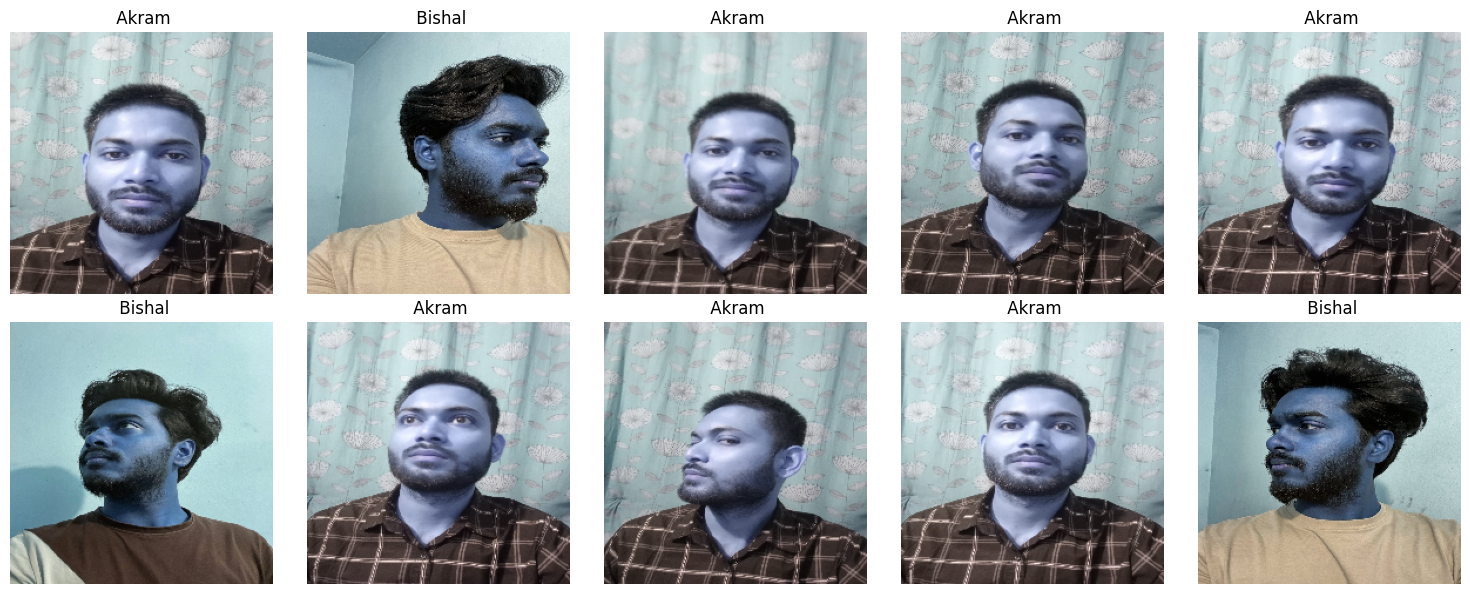

In [ ]:
# Display 10 random images
num_images_to_show = 10
indices = np.random.choice(X.shape[0], num_images_to_show, replace=False)  # Select random indices

# Plot the images using matplotlib
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Create a 2x5 grid for the images
axes = axes.flatten()  # Flatten the axes to easily iterate

for i, index in enumerate(indices):
    axes[i].imshow(X[index])  # Display the image
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f" {class_names[y[index]]}")  # Display the class name

plt.tight_layout()
plt.show()

In [ ]:
# Build a simple CNN model
model = keras.Sequential([
    keras.Input(shape=(224, 224, 3)),  # Define the input shape here
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes for 4 people
])



# Data Augmentation (optional but recommended)
# It helps with generalization and reducing overfitting
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Fit the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),  # Use data augmentation for training
    epochs=5,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=16),  # Validation data
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    validation_steps=len(X_val) // 32   # Number of batches for validation
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.1875 - loss: 1.3840 - val_accuracy: 0.3667 - val_loss: 1.3697
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3229 - loss: 1.3689 - val_accuracy: 0.3667 - val_loss: 1.3357
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2500 - loss: 1.3470 - val_accuracy: 0.3667 - val_loss: 1.3043
Epoch 4/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.4531 - loss: 1.2864 - val_accuracy: 0.3667 - val_loss: 1.2508
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3547 - loss: 1.2488 - val_accuracy: 0.3667 - val_loss: 1.1988


In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_datagen.flow(X_val, y_val, batch_size=8))

# Print the validation loss and accuracy
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.3717 - loss: 1.1972
Validation Loss: 1.198766827583313
Validation Accuracy: 0.36666667461395264


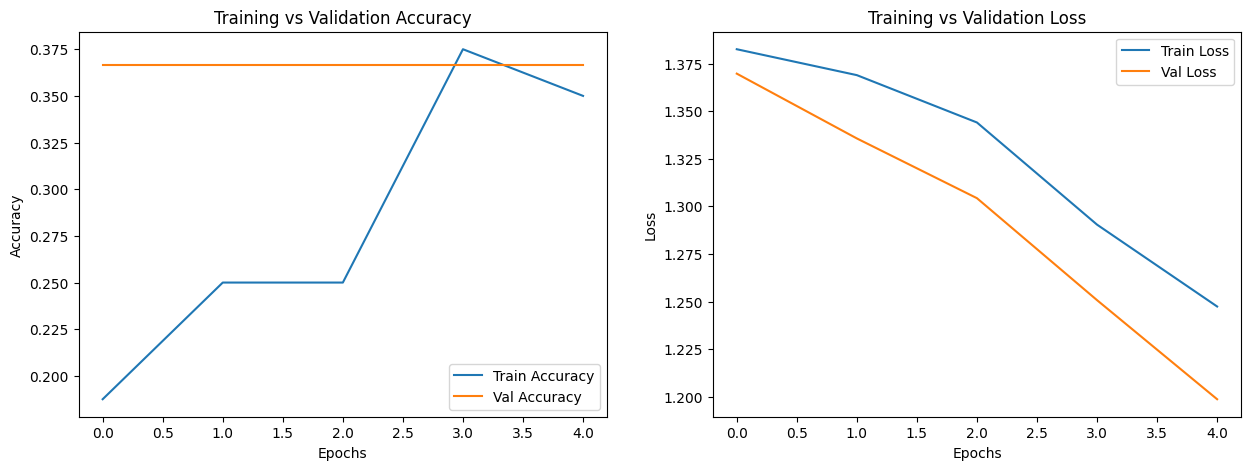

In [ ]:
plt.figure(figsize=(15,5))
# Plot training vs validation accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Plot training vs validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

model.summary()
model.save('/content/drive/MyDrive/face_recognition_model.keras')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,723,726 (273.60 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,815,818 (182.40 MB)

In [ ]:

pickle_out = open("/content/drive/MyDrive/X_train.pickle","wb")
pickle.dump(X, pickle_out)  # Changed 'images' to 'X'
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/Y_train.pickle","wb")
pickle.dump(y, pickle_out)  # Changed 'labels' to 'y'
pickle_out.close()



# Save the label encoder after training to be used for predictions
pickle_out= open("/content/drive/MyDrive/class_labels.pickle", 'wb')
pickle.dump(class_names, pickle_out)
pickle_out.close()